# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 8: Ensembles: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

## Learning Objectives
Completing this assignment will demonstrate success at the following objectives:

- Statistical
  - Predict when bagging will help model performance.
  - Identify how Random Forests improve over bagging.
  - Predict when boosting will help model performance.
  - Compare and contrast bagging and boosting.
- Coding
  - Identify and fix problems in poorly written code
- Communication
  - Visually explain a complex concept

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class="exercise"> <b> Question 1: A Single Model [20 pts]</b> </div>

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.



**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

**Answers**

**1.1**

In [6]:
def get_best_DecisionTree(x_train, y_train, max_depth):
    #Returns best model and cvscore from training set cross validation
    #also plots accuracy score
    depths = range(1,max_depth+1)
    cvmeans=[] #list of mean cross validation scores
    cvstds=[]
    scores_acc = [] #list of accuracy scores
    best_score = 0 #best cross validation mean score
    for i in depths:
        model = DecisionTreeClassifier(max_depth=i, random_state=11).fit(x_train, y_train)
        cv = cross_val_score(model, x_train, y_train, cv=5)
        cvmean = cv.mean()
        cvstd = cv.std()
        cvmeans.append(cvmean)
        cvstds.append(cvstd)
        y_pred = model.predict(x_train)
        score_acc = accuracy_score(y_train, y_pred)
        scores_acc.append(score_acc)
        if cvmean > best_score:
            best_score=cvmean
            best_model=model
    cvmeans=np.array(cvmeans)
    cvstds=np.array(cvstds)
    plt.figure(figsize=(16,10))
    plt.plot(depths, cvmeans, "*-", label="Mean Cross Validation Score")
    plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
    plt.plot(depths, scores_acc, ".-", label="Accuracy Score")
    plt.title("Scores for Varying Depth Decision Trees")
    plt.xlabel("Depth")
    plt.ylabel("Score")
    plt.xticks(depths)
    plt.ylim(.5,1)
    plt.legend()
    return best_model, best_score

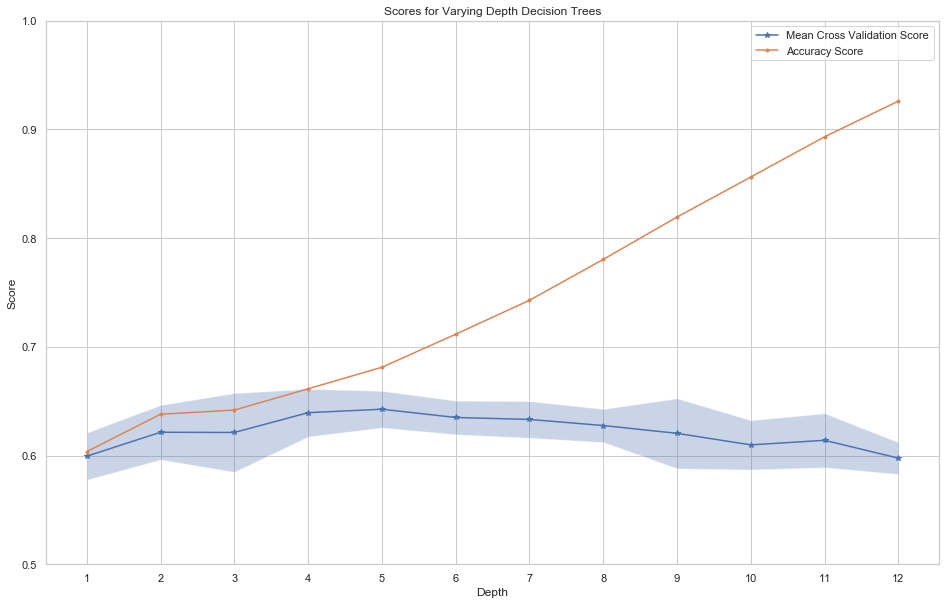

In [7]:
model_DT, best_score = get_best_DecisionTree(X_train, y_train, 12)

**1.2**

In [8]:
cv = cross_val_score(model_DT, X_train, y_train, cv=5)
print("The best decision tree had depth %i with a mean cross validation score of %.2f (+/- %.2f)"
      %(model_DT.max_depth,cv.mean(),2*cv.std()))

The best decision tree had depth 5 with a mean cross validation score of 0.64 (+/- 0.02)


In [9]:
y_pred_test = model_DT.predict(X_test)
y_pred_train = model_DT.predict(X_train)
acc_model_DT_train = accuracy_score(y_train, y_pred_train)
acc_model_DT_test = accuracy_score(y_test, y_pred_test)
print("On the training set, the classification accuracy is %.2f"%acc_model_DT_train)
print("On the test set, the classification accuracy is %.2f"%acc_model_DT_test)

On the training set, the classification accuracy is 0.68
On the test set, the classification accuracy is 0.65


A depth 5 decision tree is appropriate. It achieves the best 5 fold mean cross validation score. Based on its training and test accuracies, we observe the model is not terrible but not great. Additionally, the test set accuracy is close to the training set accuracy, so it does not seem that the model is overfit.

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

Decision trees that are too deep tend to overfit because the segmented regions in the predictor variable space become very small and specifically fitted to the particular training set. The downside of this is that the variance of the design of the tree and the variance of the response variable is large for different training sets. The low bias on the training set will dissappear when applying an overfitted decision tree to the test data. The extreme example is when all the leaves have 100% purity and the tree has perfect performance on the training data, but will have extremely high variance. The mechanisms of limiting the depth of the tree avoids creating tiny regions that are specifically fitted to the training set. Another way to think about it is that the number of samples in a region becomes too small to make a valid prediction about the classification of the region, when the tree depth is too large and the regions are too small.

By limiting the tree depth, the segmented regions are too large and their purity will be low resulting in high bias (low performace of the fitted model).

<div class="exercise"> <b> Question 2: Bagging [25 pts]</b> </div>

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single depth tree from 2.1. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

**Answers**:

**2.1**

For this question, we choose depth 12. Its cross validation mean score is relatively the same (a little worse) as the best choice tree with depth 5 from question 1.2. However, the accuracy score is very high, over 0.9, while the depth 5 tree had a much lower accuracy score. This discrepency between the cross validation score and the accuracy score leads us to believe that the depth 12 tree is overfit, making it a good choice for this question. 

In [10]:
model_DT_overfit = DecisionTreeClassifier(max_depth=12).fit(X_train,y_train)

**2.2**

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [11]:
def create_bag_dfs(X_train, y_train, X_test, y_test, replications, depth):
    rep_range = range(1,replications+1)
    df_bag_train = pd.DataFrame(columns=["Bootstap "+str(i)+" prediction" for i in rep_range])
    df_bag_test = pd.DataFrame(columns=["Bootstap "+str(i)+" prediction" for i in rep_range])
    trees=[] #list of tree objects... needed later
    for i in rep_range:
        x_boot, y_boot = resample(X_train, y_train) #resample form training data
        model=DecisionTreeClassifier(max_depth=depth, random_state=11).fit(x_boot,y_boot)
        trees.append(model)
        y_pred_train = model.predict(X_train) #training prediction
        y_pred_test = model.predict(X_test) #test prediction using model fitted to resampled training data
        df_bag_train.loc[:,"Bootstap "+str(i)+" prediction"] = y_pred_train
        df_bag_test.loc[:,"Bootstap "+str(i)+" prediction"] = y_pred_test
    return df_bag_train, df_bag_test, trees

In [12]:
replications = 45
depth = 12
bagging_train, bagging_test, trees = create_bag_dfs(X_train,y_train,X_test,y_test,replications,depth)

**2.3**

In [13]:
y_pred_train_agg = [round(np.mean(row)) for index, row in bagging_train.iterrows()]
y_pred_test_agg = [round(np.mean(row)) for index, row in bagging_test.iterrows()]

In [14]:
acc_model_DT_agg_train = accuracy_score(y_train,y_pred_train_agg)
acc_model_DT_agg_test = accuracy_score(y_test,y_pred_test_agg)
print("On the training set, the aggregated prediction accuracy is %.2f"%acc_model_DT_agg_train)
print("On the test set, the aggregated prediction accuracy is %.2f"%acc_model_DT_agg_test)

On the training set, the aggregated prediction accuracy is 0.97
On the test set, the aggregated prediction accuracy is 0.68


In [15]:
assert accuracy_score(y_test,y_pred_test_agg) >= acc_model_DT_test, "Accuracy too low"

**2.4**

In [16]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [17]:
train_running_predictions = running_predictions(bagging_train.values,y_train)
test_running_predictions = running_predictions(bagging_test.values,y_test)

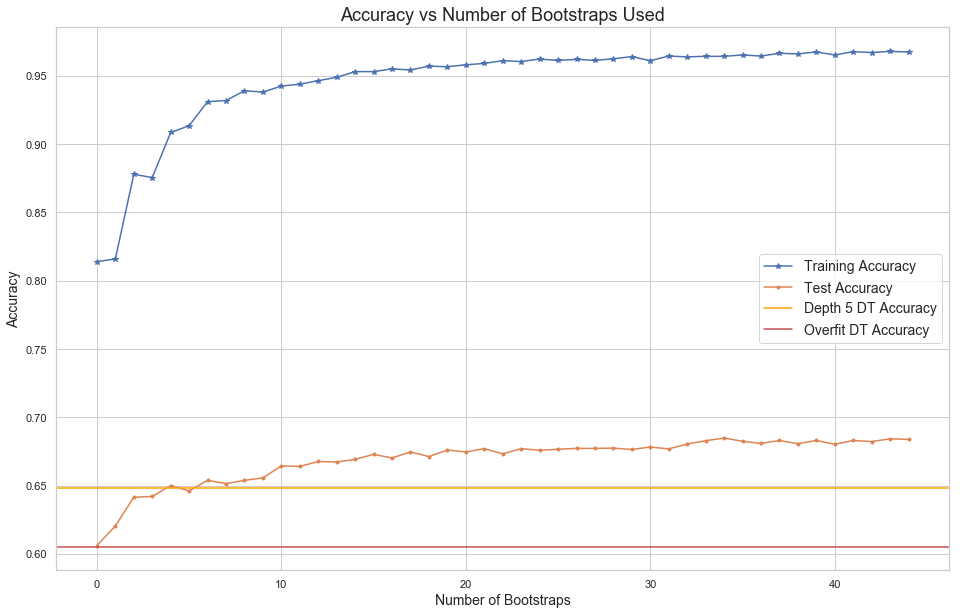

In [18]:
y_pred_test_overfit = model_DT_overfit.predict(X_test)
acc_model_DT_overfit_test =accuracy_score(y_test,y_pred_test_overfit)

y_pred_train_overfit = model_DT_overfit.predict(X_train)
acc_model_DT_overfit_train =accuracy_score(y_train,y_pred_train_overfit) #for later

plt.figure(figsize=(16,10))
plt.plot(train_running_predictions, "*-", label="Training Accuracy")
plt.plot(test_running_predictions, ".-", label="Test Accuracy")
plt.axhline(y=acc_model_DT_test, color="orange", label="Depth 5 DT Accuracy")
plt.axhline(y=acc_model_DT_overfit_test, color="r", label="Overfit DT Accuracy")
plt.title("Accuracy vs Number of Bootstraps Used",fontsize=18)
plt.ylabel("Accuracy",fontsize=14)
plt.xlabel("Number of Bootstraps",fontsize=14)
plt.legend(fontsize=14);

**2.5**

The bagged model quite immediately performs betters than the single DT, initially improving its accuracy with every additional bootstrap (though with diminishing returns) until eventually, around the 24th bootstrap, the accuracy levels out despite additional bootstraps. The improvement is because by using an ensemble approach and 'averaging' the outcome across multiple bootstrapped decisions trees, some of the overfitting of the single DT is avoided.

**2.6**

Limiting tree depth reduces overfitting by limiting the tree's complexity which might otherwise go as far as building a DT where each leaf has 100% purity so it perfectly predicts the training set but has high variance, which means it won't fit new data well. Limiting tree depth reduces such overfitting, but also produces higher bias alongside the lower variance. Our chart demonstrates how limiting the depth can lead to higher performance through this manner as the Depth 5 DT outperforms the Depth 12 DT. 

Bagging manages to sidestep the increase in bias (limit in model complexity) that limiting tree depth causes while also keeping variance low (and so not overfit). It does so by aggregating a multitude of bootstrapped overfit models. The larger depth of those models keeps bias low because the regions can better approximate irregular regions in the predictor space, while averaging over all those models in turn keeps the variance low. This is why the bagged model not only improves on the single overfit model but also eventually outperforms the Depth 5 model once there are enough bootstraps for the averaging to have a big enough effect on the variance.

**2.7**

1. The bagging classifier can still overfit if the tree depth is too large and underfit of the DT is too shallow to begin with.
2. The fact that DT can only fit rectangular areas (rather than curved ones) can lead to underfitting.
3. The DTs in the ensemble of trees are highly correlated, because they tend to all split on strong predictors in early iterations. This means that there is not enough variability among the DTs to counteract the overfitting.

<div class="exercise"> <b> Question 3: Random Forests [15 pts]</b> </div>

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.



**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.

**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

**Answers**:

**3.1**

In [19]:
model_RF_overfit = RandomForestClassifier(n_estimators=45,max_depth=12).fit(X_train,y_train)

In [20]:
acc_model_RF_overfit_train = accuracy_score(y_train,model_RF_overfit.predict(X_train))
acc_model_RF_overfit_test = accuracy_score(y_test,model_RF_overfit.predict(X_test))
print("On the training set, the random forest classification accuracy is %.2f"%acc_model_RF_overfit_train)
print("On the test set, the random forest classification accuracy is %.2f"%acc_model_RF_overfit_test)

On the training set, the random forest classification accuracy is 0.97
On the test set, the random forest classification accuracy is 0.70


There is still a significant difference between the training set accuracy and the test set accuracy.

**3.2** 

In [21]:
top_features_DT = [tree.tree_.feature[0] for tree in trees]
top_features_RF = [tree.tree_.feature[0] for tree in model_RF_overfit.estimators_]

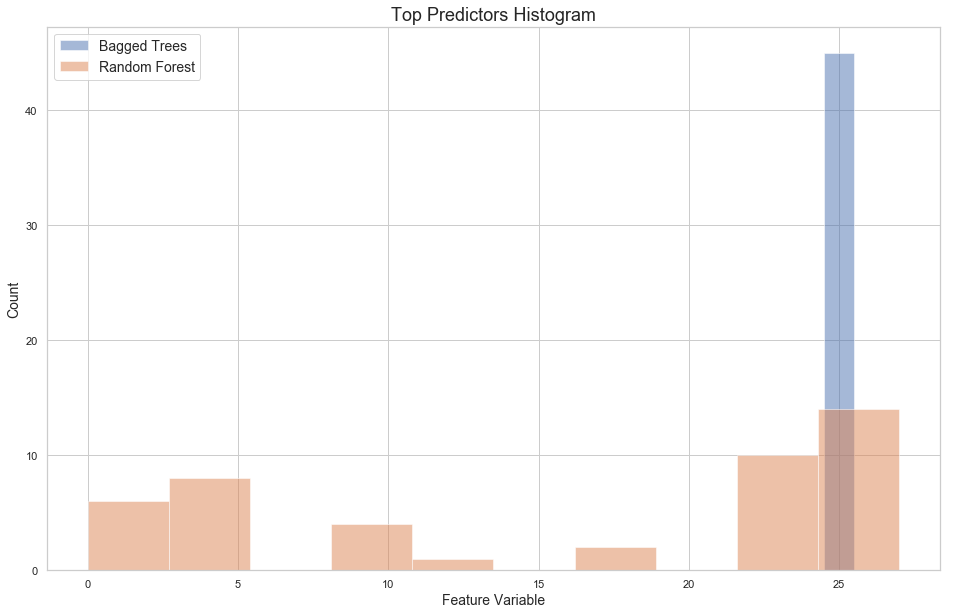

In [22]:
plt.figure(figsize=(16,10))
plt.hist(top_features_DT, bins=1, label="Bagged Trees", alpha=0.5)
plt.hist(top_features_RF, label="Random Forest", alpha=0.5)
plt.title("Top Predictors Histogram", fontsize=18)
plt.xlabel("Feature Variable", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.legend(fontsize=14)
plt.show()

The DTs fit in the bagging process only ever use feature variable 25 at their top node, unlike the decision trees in the random forest which use feature 25 only twenty-two times and otherwise leverage plenty of other feature variables. This is likely because feature variable 25 is a strong indicator that the greedy algorithm subsequently prioritizes at the top node of every tree in the bagged model. The random forest avoids the same fate  because the random forest process randomly leaves out certain variables on each level to reduce correlation among the bootstrapped DTs, and so trees in the random forest that don't feature variable 25 in their top node likely had that variable left out. 

As a result, the random forest model will likely perform more accurately because it has a higher likelihood of experiencing the most optimal tree structures since it sees many more versions while the bagged model is blind to any decision tree that doesn't start with the strong indicator, feature variable 25, which isn't necessarily the optimal classification path. Moreover, the random forest process reduces the correlation among the decision trees. 

**3.3** What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

Fill in the following table (ideally in code, but ok to fill in this Markdown cell).


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 45 depth-X trees | | |
| Random Forest of 45 depth-X trees | | |

In [23]:
df_scores = pd.DataFrame(index=["single tree with best depth chosen by CV","single depth-12 tree",
                               "bagging 45 depth-12 trees", "Random Forest of 45 depth-12 trees"],
                        columns=["Training Accuracy","Test Accuracy"])
df_scores["Training Accuracy"]["single tree with best depth chosen by CV"] = acc_model_DT_train
df_scores["Test Accuracy"]["single tree with best depth chosen by CV"] = acc_model_DT_test
df_scores["Training Accuracy"]["single depth-12 tree"] = acc_model_DT_overfit_train
df_scores["Test Accuracy"]["single depth-12 tree"] = acc_model_DT_overfit_test
df_scores["Training Accuracy"]["bagging 45 depth-12 trees"] = acc_model_DT_agg_train
df_scores["Test Accuracy"]["bagging 45 depth-12 trees"] = acc_model_DT_agg_test
df_scores["Training Accuracy"]["Random Forest of 45 depth-12 trees"] = acc_model_RF_overfit_train
df_scores["Test Accuracy"]["Random Forest of 45 depth-12 trees"] = acc_model_RF_overfit_test
df_scores

,Training Accuracy,Test Accuracy
single tree with best depth chosen by CV,0.6812,0.648
single depth-12 tree,0.926,0.605
bagging 45 depth-12 trees,0.9676,0.6838
Random Forest of 45 depth-12 trees,0.9734,0.6952


- The overfitted depth-12 DT has better performance on the training set and worse performance on the test set compared to the best-depth DT as expected, because the regions are too specifically fit for to the training data causing high variance.
- The 45 depth-12 bagging classifier improves on the regular depth-12 DT test accuracy as expected because it reduces overfitting. The fact that it also performs better on the training accuracy is a bit surprising because bootstrapping uses the same underlying samples.
- The random forest of 45 depth-12 trees performs better on the test set compared to the bagging 45 depth-12 trees as expected, because by reducing correlation among the bootstrapped DTs it reduces overfitting. The fact that it also performs better on the training set is not as expected because on average the DTs are expected to perform worse on the training set because often the optimal predictor is left out. However this can easily be explained from the nature of the greedy algorithm, which is not guaranteed to find the optimal solutions. It is similar to how adding randomness can get you out of a local minimum.

<div class="exercise"> <b> Question 4: Boosting [15 pts]</b> </div>

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.



**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**Answers**

**4.1**

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [24]:
def plot_predictor_distribution(df_train, target, nrows, ncols, max_depth=3):
    #plots correct and incorrect predictor distributions
    X_train = df_train.iloc[:, df_train.columns != target]
    y_train = df_train[target]
    
    assert nrows*ncols >= len(X_train.columns), "Subplot space smaller than predictor space"
    
    tree1 = DecisionTreeClassifier(max_depth=max_depth).fit(X_train,y_train)
    tree1_pred_train = tree1.predict(X_train)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
    plt.subplots_adjust(hspace=.6, wspace=.6)
    fig.suptitle("Distribution of Predictor Values: Correct and Incorrect", y=0.93, fontsize=18)
    axes_list = axes.ravel()
    
    for i, label in enumerate(X_train.columns):
        X_correct = X_train[tree1_pred_train == y_train][label]
        X_incorrect = X_train[tree1_pred_train != y_train][label]
        
        ax = axes_list[i]
        sns.kdeplot(X_correct, ax=ax, label="Correct")
        sns.kdeplot(X_incorrect, ax=ax, label="Incorrect")
        ax.set_xlabel("Predictor Value")
        ax.set_ylabel("Density")
        ax.set_title(label)
        ax.legend()

/Users/dylan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


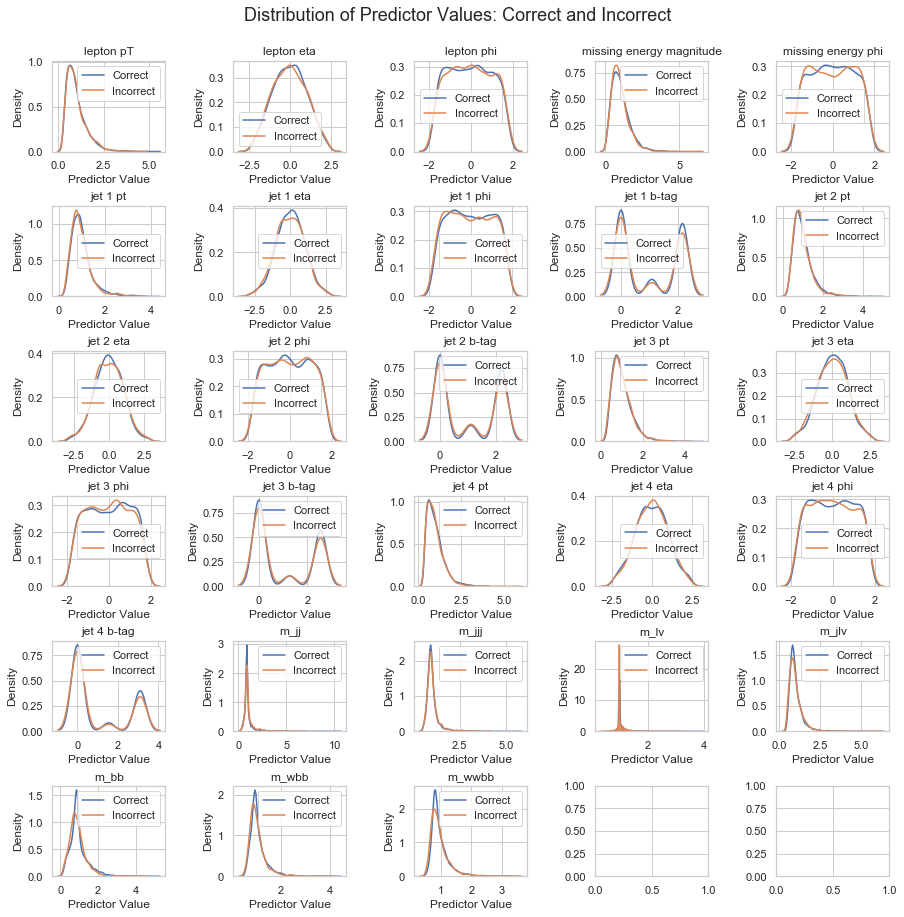

In [25]:
plot_predictor_distribution(data_train,"class", 6, 5, max_depth=3)

The majority of predictors have a nearly identical distribution of correct or false predictions across their value range. However, there are some predictors that have a higher density of correct predictions, which is especially noticeable around the area of highest density in their value range. These predictors are: jet 1 eta, jet 1 b-tah, jet 2 eta, jet 2 b-tag, jet 3 b-tag, jet 4 b-tag, m_jj, m_jlv, m_bb, m_wbb, m_wwbb. Only 'jet 4 eta' seem to have a slighly lower incidence of correct predictions. 


**4.2**

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [26]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


Stylistic problems: 
- the function does not take any inputs, nor have any outputs, so is not generalizable at all. 
- `q`, `t1p`, and others are bad undescripitive variable names.
- code is repeated for train and test, writing a helper function would have been better
- could have used np.arrays and list comprehension effectively as oppose to iterating over lists
- improper indentation on the first if statement (hence why its red)
- poor commenting of code and description of function
- many unnecessary lines like `q = q + 0` and calculating `t1p` and `t2p` when they are equal; additionally adding them and dividing by 2 to get `m` is super redundant when `t1p = m`

Functional problems:  
- the boosted accuracies should be higher but clearly arent
- reporting of accuracies and building of models would in best practice be seperate functions
- improper resetting of `q` variable to 0 when it should be just `q` or the writers redundant `q = q + 0`; this is likely why the accuracy is so bad
- keeping a list of trees and being able to generalize beyond two boosted trees would make functionality better

In [27]:
def AdaBoost(X_train, y_train, max_depth, ntrees, learning_rate=2, sample_weights=None):
    #returns list of boosted trees
    
    if sample_weights is None:
        #sample weights length matches number of samples in dataset
        sample_weights = np.ones(X_train.shape[0]) #start with all ones
    
    trees_boost = [] #return list of boosted trees
    
    for i in range(ntrees):
        #fit new tree with calculated sample weights
        tree = DecisionTreeClassifier(max_depth=max_depth).fit(X_train,y_train,sample_weight=sample_weights)
        trees_boost.append(tree)
        tree_pred = tree.predict(X_train)
        incorrect_idx = tree_pred != y_train #find incorrect predictions
        #weight incorrect predictions by learning weight
        sample_weights[incorrect_idx] = sample_weights[incorrect_idx]*learning_rate 
    return trees_boost

In [28]:
def accuracy_boosted_trees(trees_boost, X, y):
    #gets predictions from probabilities by rounding and returns accuracy
    
    #make predictions
    predictions = np.around(np.mean(np.array([tree.predict_proba(X)[:,1] for tree in trees_boost]),axis=0))
    return accuracy_score(y, predictions) #return accuracy

In [29]:
ntrees=10
depth_boost = 3
trees_boost = AdaBoost(X_train, y_train, depth_boost, ntrees)

In [30]:
model_DT_3 = DecisionTreeClassifier(max_depth=3).fit(X_train,y_train)
acc_DT_3_train = accuracy_score(y_train, model_DT_3.predict(X_train))
acc_DT_3_test = accuracy_score(y_test, model_DT_3.predict(X_test))
acc_boost_train = accuracy_boosted_trees(trees_boost, X_train,y_train)
acc_boost_test = accuracy_boosted_trees(trees_boost, X_test,y_test)
print("On the training set, the accuracy score for the depth 3 tree is %.5f"%acc_DT_3_train)
print("On the test set, the accuracy score for the depth 3 tree is %.5f"%acc_DT_3_test)
print("On the training set, the accuracy score for "+
      "the boosted model (%i boosts) is %.5f"%(ntrees, acc_boost_train))
print("On the test set, the accuracy score for "+ 
      "the boosted model (%i boosts) is %.5f"%(ntrees, acc_boost_test))

On the training set, the accuracy score for the depth 3 tree is 0.64180
On the test set, the accuracy score for the depth 3 tree is 0.64420
On the training set, the accuracy score for the boosted model (10 boosts) is 0.69540
On the test set, the accuracy score for the boosted model (10 boosts) is 0.67800


**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

In [31]:
model_Ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                               learning_rate=0.05,n_estimators=800).fit(X_train,y_train)

In [32]:
acc_Ada_train = list(model_Ada.staged_score(X_train,y_train))
acc_Ada_test = list(model_Ada.staged_score(X_test,y_test))

In [33]:
def plot_Ada_accs(acc_train, acc_test, title, fontsize_title=18, fontsize_legend=14):    
    plt.title(title, fontsize=fontsize_title)
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Classification Accuracy")
    plt.plot(acc_train, label="Training")
    plt.plot(acc_test, label="Test")
    plt.legend(fontsize=fontsize_legend);

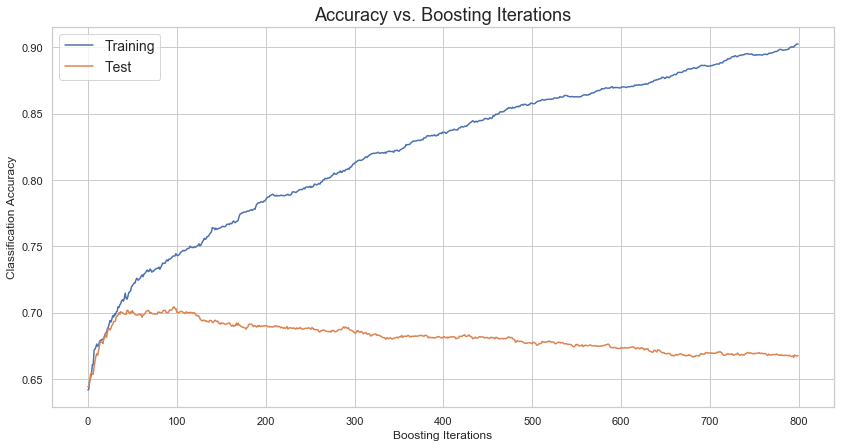

In [34]:
plt.figure(figsize=(14,7))
plot_Ada_accs(acc_Ada_train, acc_Ada_test, title="Accuracy vs. Boosting Iterations")

**4.4**

In [35]:
def plot_Ada_accs_depths(X_train,y_train,X_test,y_test, nrows, ncols, figsize,
                        depths=[1,2,3,4],learning_rate=0.05,n_estimators=800):
    #plot training and test AdaBoost accuracies at varying depths
    #return the best depth, iterations, and accuracy based on test set accuracy
    
    assert nrows*ncols >= len(depths), "Subplot space smaller than number of depths"
    plt.figure(figsize=figsize)
    
    best_acc = 0 #best test accuracy
    best_depth=0
    best_iters=0
    
    for i, depth in enumerate(depths, 1):
        model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),
                                   learning_rate=learning_rate,
                                   n_estimators=n_estimators).fit(X_train,y_train)
        acc_train = list(model.staged_score(X_train,y_train))
        acc_test = list(model.staged_score(X_test,y_test))
        
        acc = max(acc_test)
        if acc > best_acc:
            best_acc = acc
            best_depth = depth
            best_iters = np.argmax(acc_test)
        
        plt.subplot(nrows,ncols, i)
        plot_Ada_accs(acc_train, acc_test, title="Depth = "+str(depth), 
                      fontsize_title=14, fontsize_legend=12)
        
    plt.suptitle("AdaBoost Accuracies Over Boosting Iterations at Varying Depths", 
                 fontsize=18, y=0.95)
    plt.subplots_adjust(hspace=.3, wspace=.3)
    
    return best_depth, best_iters, best_acc

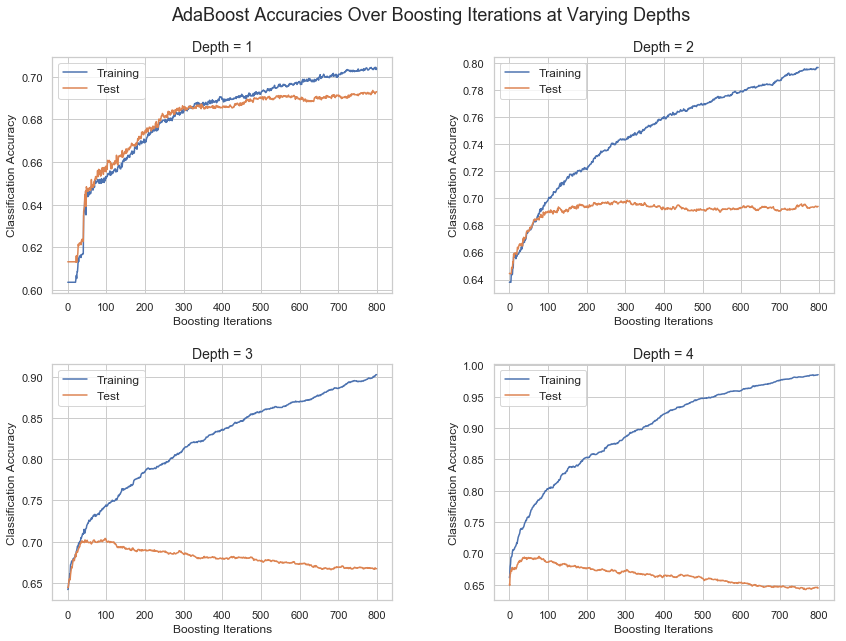

In [36]:
best_depth, best_iters, best_acc = plot_Ada_accs_depths(X_train,y_train,X_test,y_test,2,2,figsize=(14,10))

We see that the training accuracies trend towards 1.0 as the number of iterations increases (this effect is more pronounced at higher depths) even though the test accuracy deterioriate, a symptom of overfitting to the training data caused by minimizing the residuals with the training data. Interestingly, the testing accuracies pretty closely tracked the training accuracies for the depth 1 tree up to a high number of iterations, while for depth 3 and higher, the test accuracies reach their optimal after a lower number of iterations but then quickly taper off.

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

Based on eyeballing the test accuracies in the plots above, it seems like depth 3 at 100 boosting iterations is optimal. We cant use training accuracy to figure out what is optimal as it would lead us to extremely high depth trees and high boosting iterations because of overfitting. To see what is exactly optimal, we can look at the return values from our `plot_Ada_accs_depths` function.

In [37]:
print("The best AdaBoost model had learner depth of %i with %i iterations and achieved a test accuracy of %.3f"
     %(best_depth, best_iters, best_acc))

The best AdaBoost model had learner depth of 3 with 97 iterations and achieved a test accuracy of 0.704


Our eyeballing was incredibly close to optimal. Additionally the performance of this model is even better than the other ensemble models considered above. Success!

<div class="exercise"> <b> Question 5: Understanding [15 pts]</b> </div>

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

**Answers**:

**5.1**

Both bagging and boosting are both ensemble methods which make a model out of many trees. In the case of bagging the ensemble trees are bootstrapped samples from the training set. In the case of boosting, the initial tree is a SIMPLE model based on the training set and subsequent trees are fitted to the current residiuals. Another difference is that bagging uses the average of the predictions of the ensemble of trees, while for boosting the prediction is calculated by recursively adding a lambda factor times the prediction of the tree fitted to the residuals to the prediction of the previous tree. 

**5.2**

The ranking in overall performance based on test set accuracy:
1. Sklearn AdaBoost (base depth 3, learning rat 0.05, 97 iterations): 0.704
2. Random Forest (45 depth, 12 trees): 0.6876
3. Bagging (45 depth, 12 trees): 0.6866
4. Single DT with best depth chosen by CV: 0.648

Bagging outperforms single DT because of reduced overfitting by averaging across an ensemble of bootstrapped tree. 

Random Forest (narrowly) beats bagging because by removing correlation between bootstrapped DTs by using random subset of predictors

Sklearn Adaboost outperforms all others because it can use gradient descent to direcly minimize classifcation error, more than making up for the lower depth of the DT.


**5.3**

Boosting is susceptible to overfitting to the training data by having too many trees as can be seen in the charts in 4.4 because it is driven by reducing the residuals from the training data (at some point there could be a 100% fit with the training data). This effect is stronger for higher depth trees.

Even though bagging uses higher depth trees, it is less susceptible to overfitting by having too many trees, because averaging over an ensemble of trees largely counteracts this effect.

**5.4**

Bagging is best suited for parallelization because each DT is created from an independent bootstrap sample and can thus be generated in parallel.
Boosting is not well suited for parallelization because the DT in each iteration is dependent on the DT generated in the previous iteration, making it a sequential process.

**5.5**

In general decision trees can be extended for regression (rather than classification) tasks by making the following modifications:
1. The splitting criterion must reduce the MSE (or similar measure) instead of the purity
2. Each region in the predictor space must be labeled with a real number (rather than a class), for example the average of the response variable values contained in the region

Bagging, Random Forest and Gradient Boosting are all commonly used for regression tasks in this way.

Adaptive Boosting (Ada Boost) is normally used for classification tasks, but could also be extended to accomdoate regression tasks as follows:
- The DT is modified as described above
- Rather than increasing the weight of the samples that are wrongly predicted, we could increase the weight of the samples relative to the size of their residual with the training set.

<div class="exercise"> <b> Question 6: Explaining Complex Concepts Clearly [10 pts]</b> </div>

One of the core skills of a data scientist is to be able to explain complex concepts clearly. To practice this skill, you'll make a short presentation of one of the approaches we have recently studied.

**Choose one of the following topics:**

- Decision Trees
- Random Forests
- Bagging
- Boosting
- Simple Neural Nets (like the MLP we saw in Homework 6)
- (other topics are possible, but get staff approval first)

**Make 3 slides explaining the concept.**

- Focus on **clear explanations**, NOT aesthetic beauty. Photos of pen-and-paper sketches are fine if they're legible.
- For your audience, choose **future CS109A students**.
- You may take inspiration from anywhere, but explain in **your own words** and **make your own illustrations**.


Submit your slides as a PDF and the source format (`.pptx`, Google Slides, etc.)

NOTE: If you would be okay with us using your slides for future classes (with attribution, of course), please include a note to that effect. This will not affect your grade either way.